In [1]:
!pip install neo4j
!pip install python-igraph
!pip install easygui
!pip install cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 2.6 MB/s 
  Created wheel for neo4j: filename=neo4j-4.4.3-py3-none-any.whl size=116069 sha256=9f80a5445ccf61b08b3405bd8f8138162f571246bfa64d89f92daeb7767e014f
  Stored in directory: /root/.cache/pip/wheels/db/dd/76/acacd519878f133f2f869aec70db548d89e04013209c3c62bc
Successfully built neo4j
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 7.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 204 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.5 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=bf9c426

In [19]:
from neo4j import GraphDatabase
import igraph as ig
from skimage.io import imread
import glob
import seaborn as sns 
import matplotlib.pyplot as plt 
import os
import pandas as pd
import warnings
import random
import numpy as np
import random
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [20]:
z = ig.Graph.Read_GraphML("/content/drive/My Drive/ALSSN/zurich.graphml")

In [5]:
z.edge_attributes(), z.vertex_attributes()

(['weight', 'label', 'id'], ['location', 'id', 'labels'])

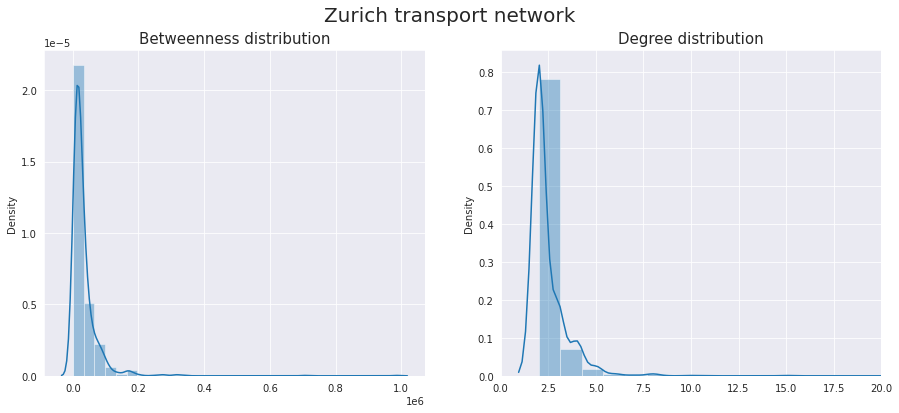

In [6]:
btw = z.betweenness()
deg = z.degree()
sns.set_style('darkgrid')
plt.figure(figsize=(15,6))
plt.suptitle('Zurich transport network', fontsize=20)
plt.subplot(121)
sns.distplot(btw, bins=30)
plt.ticklabel_format(axis='x', style='sci', scilimits=[0, .6])
plt.title('Betweenness distribution', fontsize=15)
plt.subplot(122)
sns.distplot(deg, bins=30)
plt.xlim([0,20])
plt.title('Degree distribution', fontsize=15);


In [ ]:
z.vcount(), z.is_directed(), z.is_weighted()

(1346, True, True)

In [ ]:
# for c in glob.glob('*png'):
#   os.remove(c)

In [192]:
def generate_graph(graph, modules, iteration=None, delete_previous_plots=True, layout='auto'):
  if not os.path.exists('clusters/'):
    os.mkdir('clusters/')
    
  if delete_previous_plots and iteration==1:
    for c in glob.glob('clusters/cluster*png'):
      os.remove(c)

  layout_gr = graph.layout(layout)

  colors =np.random.permutation(sns.color_palette("hls", len(modules))).tolist()
  #colors = sns.color_palette("hls", k)
  graph.vs['color'] = [None]
  for clid, cluster in enumerate(modules):
      for member in cluster:
          graph.vs[member]['color'] = colors[clid]

  visual_style = {}
  visual_style["vertex_size"] = 5
  visual_style["vertex_label"]=None
  visual_style["vertex_color"] = graph.vs['color']
  visual_style["layout"] = layout_gr
  visual_style["edge_width"] = 1
  visual_style["bbox"] = (300, 300)
  pl = ig.plot(graph, **visual_style)
  if iteration:
    pl.save('clusters/clusters_{}_iter{}.png'.format(len(modules), iteration))
  else:
    pl.save('clusters/clusters_{}.png'.format(len(modules)))
  #return pl

def plot_graphs(img_path='clusters/', plot_limit=20, sample=False):
  i = 1
  # retrieve image fileanmes and sort them accordingly to iteration
  img_list = glob.glob(os.path.join(img_path,'cluster*.png'))

  # sample images or pick the first 0 to plot_limit ones
  if sample and len(img_list) > plot_limit:
    img_list = random.sample(img_list, plot_limit)
  else:
    img_list = img_list[:plot_limit]

  img_list.sort(key = lambda x: int(x.split('_')[-1][4:-4]))
  
  # set subplot dimensions
  if len(img_list)%2!=0:
    rows = len(img_list)//2
    cols = len(img_list)//4 + 1
  else:
    rows = len(img_list)//2
    cols = len(img_list)//4

  if rows==0 and cols==0:
    rows = 1
    cols=1
  elif rows == 0:
    rows=1

  for imf in img_list:
      im = imread(imf)
      plt.subplot(cols,rows,i)
      plt.imshow(im)
      t = 'iteration ' + imf.split('_')[-1][4:-4] + '\n' +'n_clusters: ' + imf.split('_')[1] 
      plt.title(t, fontsize=15)
      plt.xticks([])
      plt.yticks([])
      i += 1

Analysis carried out by iteratively removing the node with the highest betweenness centrality. At each iteration the following metrics are computed: communities with Leiden algorithm, shortest paths between pairs of selected nodes, modularity and betweenness measures 

In [126]:
def get_most_central_node(subgraph, ref_ids=[], method='bwt'):
  # ref ids are the list of nodes that we do not want to remove from our graphs because they 
  # represent the nodes between which we want to compute the shortest paths
  if method=='btw':
    # Approach of most central node selection taken from excercise session 3
    betw = subgraph.betweenness(weights=subgraph.es["weight"])
    # Select node with the highest degree and betweenness
    vind = subgraph.vs[np.where(betw==np.amax(betw))[0][0]].index
    vid = subgraph.vs[np.where(betw==np.amax(betw))[0][0]]['id']
    while vind in ref_ids:
      betw.remove(np.amax(betw))
      vind = subgraph.vs[np.where(betw==np.amax(betw))[0][0]].index
      vid = subgraph.vs[np.where(betw==np.amax(betw))[0][0]]['id']
      
  elif method=='eig_cent':
    cent = subgraph.eigenvector_centrality()
    vind = subgraph.vs[np.argmax(cent)].index
    vid = subgraph.vs[np.argmax(cent)]['id']
    while vind in ref_ids:
      cent.remove(np.amax(cent))
      vind = subgraph.vs[np.argmax(cent)].index
      vid = subgraph.vs[np.argmax(cent)]['id']
  return vind, vid

In [115]:
def compute_spath_weight(graph, target_spaths):
  # this function takes the graph and the pre-computed shortest paths for a given list of reference points and returns a 
  # dictionary containing for each of them the total weight of their shortest path
  spath_weights = {}
  for targetpath in target_spaths:
    spaths=target_spaths[targetpath]
    pathweight=0
    for l in range(len(spaths[0])-1):
      eid = graph.get_eid(spaths[0][l], spaths[0][l+1], directed=False)
      pathweight += graph.es[eid]["weight"]
    spath_weights[targetpath] = pathweight
  return spath_weights

In [210]:
def get_spaths_node_ids(graph, target_spaths):
  # this function takes the graph and the pre-computed shortest paths for a given list of reference points and 
  # and convert the nodes indexes in the shortest path to node ids
  spath_ids = {}
  for targetpath in target_spaths:
    spaths=target_spaths[targetpath]
    spath_ids[targetpath] = [graph.vs[n]['id'] for n in spaths[0]]
  return spath_ids

In [92]:
def retrieve_internal_ids(graph, ref_substop_ids):
  # converts node ids to graph indexes
  ref_node_ids = []
  for v in graph.vs:
    if int(v['id']) in ref_substop_ids:
      ref_node_ids.append(v.index)
  return ref_node_ids

In [ ]:
def compute_shortest_path(graph, pairs):
  shortest_paths = {}
  for p in pairs:
    pair_indexes = retrieve_internal_ids(graph, list(p))
    shortest_paths[str(p)] = graph.get_shortest_paths(pair_indexes[0], to=pair_indexes[1], weights=graph.es["weight"], output="vpath",)
  return shortest_paths

In [176]:
def process(graph_undirected, pairs, ref_substop_ids, iterations=10, save_plots=True):
  patience = 0
  i = 0
  metrics = pd.DataFrame(columns=['subgraph', 'modules', 'iteration', 'betweenness', 'shortest_path', 'modularity'])
  while (patience <= 3) & (i <= iterations):
    #for i in range(iterations):
    if i==0:
      # in the first iteration we don't remove anything, we just compute the baseline measures
      subgraph = graph_undirected.copy() 
      msg = 'number of nodes: {}, number of edges: {}'.format(subgraph.vcount(), subgraph.ecount())
      v_id = None
    else:
      # get most central vertex
      ref_ids = retrieve_internal_ids(subgraph, ref_substop_ids) 
      v_ind, v_id = get_most_central_node(subgraph, ref_ids, method='btw') 
      # remove from subgraph
      subgraph.delete_vertices(v_ind)
      msg = 'ITER{} removed node {}, number of nodes: {}, number of edges: {}'.format(i, v_id, subgraph.vcount(), subgraph.ecount())
    leid = subgraph.community_leiden(weights=subgraph.es["weight"], resolution_parameter=.5) # the lower resolution_parameter the lesser communities (i.e. bigger clusters)
    #leid = subgraph.community_multilevel()
    sp = compute_shortest_path(subgraph, pairs)
    sw = compute_spath_weight(subgraph, sp)
    spids = get_spaths_node_ids(subgraph, sp)
    row = pd.Series(data = {'subgraph': subgraph.copy(), 
                            'iteration': i, 
                            'modules': leid,
                            'betweenness': subgraph.betweenness(weights=subgraph.es["weight"]), #
                            'shortest_paths': sp,
                            'shortest_path_weights':sw,
                            'modularity': leid.modularity,
                            'n_clusters': len(leid),
                            'removed_node_id':v_id,
                            'n_edges':subgraph.ecount(),
                            'n_nodes':subgraph.vcount(),
                            'shortest_path_ids': spids})
    metrics = metrics.append(row, ignore_index=True)
    if save_plots:
      generate_graph(subgraph, leid, iteration=i+1, layout='drl')
    print(msg)

    if max(sp.values())==0:
      patience += 1
    else:
      patience = 0
    i+=1

  return metrics

In [161]:
def generate_random_pairs(n_pairs, graph, source_list=[]):
  # random pairs of nodes to be considered as ends of the shortest paths to monitor. can be selected randomly from the graph or from a given list of node ids
  j = 0
  pairs = []
  while j < n_pairs:
    if not source_list:
      ids_list = np.random.choice(graph.vs['id'], 2)
      p = (int(ids_list[0]), int(ids_list[1])) 
    else:
      ids_list = np.random.choice(source_list, 2) # repeat 
      p = (ids_list[0], ids_list[1]) 
    if (p not in pairs) and (p[0]!=p[1]):
        pairs.append(p)
        j+=1
  return pairs, ids_list

In [177]:
# convert network to undirected in order to perform the Louvain algorithm
substop_path = '/content/drive/My Drive/ALSSN/touristic_substops.xlsx'
touristic_substops = pd.read_excel(substop_path)
z_undirected = z.copy()
z_undirected.to_undirected(combine_edges=dict(weight="sum"))
pairs, ref_node_ids = generate_random_pairs(8, z_undirected, touristic_substops['ID SUBSTOP'].to_list())
metrics = process(z_undirected, pairs, ref_node_ids, iterations=10, save_plots=True)

number of nodes: 1346, number of edges: 1657
ITER1 removed node 46016, number of nodes: 1345, number of edges: 1636
ITER2 removed node 46024, number of nodes: 1344, number of edges: 1609
ITER3 removed node 47747, number of nodes: 1343, number of edges: 1606
ITER4 removed node 44487, number of nodes: 1342, number of edges: 1600
ITER5 removed node 45736, number of nodes: 1341, number of edges: 1587
ITER6 removed node 43732, number of nodes: 1340, number of edges: 1583
ITER7 removed node 46697, number of nodes: 1339, number of edges: 1579
ITER8 removed node 45902, number of nodes: 1338, number of edges: 1570
ITER9 removed node 45994, number of nodes: 1337, number of edges: 1566
ITER10 removed node 43774, number of nodes: 1336, number of edges: 1561


### Graph topology changes across iterations

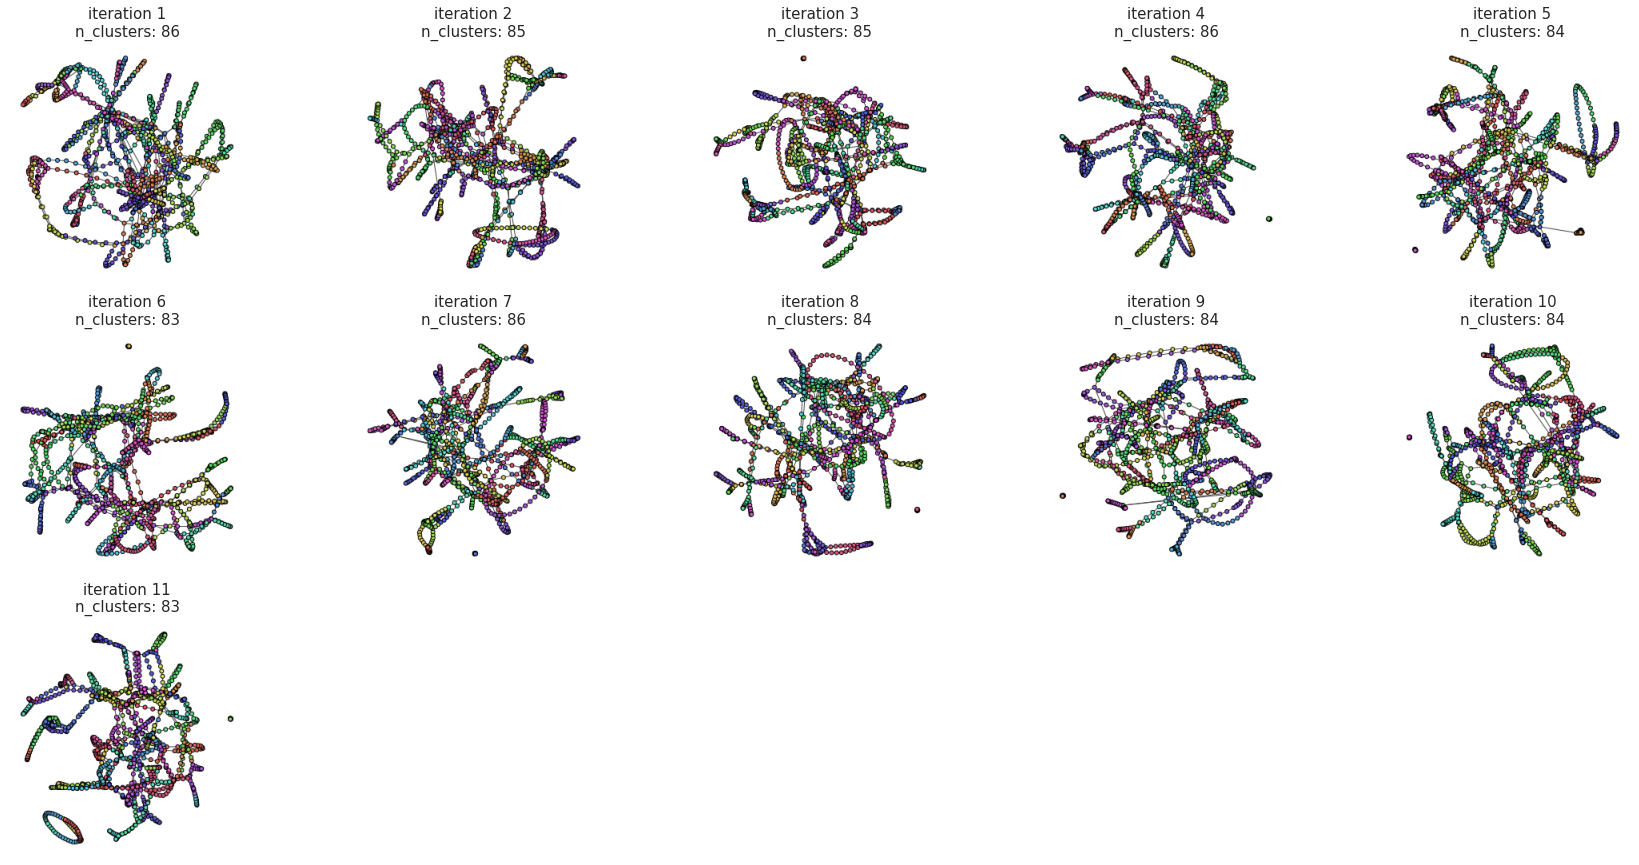

In [198]:
plt.figure(figsize=(30, 15))
plot_graphs(sample=True)

Clusters become more and more separated across iterations as expected. we should check whether we get to a condition in which we have pretty well separated clusters consisting of multiple nodes (i.e. not only one node clusters)

### Shortest path changes between node pairs across iterations

In [199]:
def shortest_path_graph(graph, gspaths, iteration, delete_previous_plots=True):
  """
  graph: current subgraph or main graph 
  gspaths: all the graph shortest paths being monitored at the current iteration
  """
  if not os.path.exists('shortest_paths/'):
    os.mkdir('shortest_paths/')

  if delete_previous_plots and iteration==1:
    for c in glob.glob('shortest_paths/spaths*png'):
      os.remove(c)

  # set default layout properties
  layout_gr = graph.layout('drl')
  colors =sns.color_palette("hls", len(gspaths))
  graph.vs['color'] = ['black']
  graph.vs['size'] = 2

  i = 0

  # iterate over all the node pairs for which the shortest path are computed at each iteration 
  for spaths in gspaths:
        # pick paths related to one pair of node in the list
        path = gspaths[spaths][0]
        # each pair might contain more than one shortest path (not sure why...but it returns a list)
        for n in path:
          graph.vs[n]['color'] = colors[i]
          graph.vs[n]['size'] = 10
        i+=1
  visual_style = {}
  visual_style["vertex_size"] = graph.vs['size']
  visual_style["vertex_label"]=None
  visual_style["vertex_color"] = graph.vs['color']
  visual_style["layout"] = layout_gr
  visual_style["edge_width"] = 1
  visual_style["bbox"] = (300, 300)
  pl = ig.plot(graph, **visual_style)
  pl.save('shortest_paths/spaths_iteration_{}.png'.format(iteration))

def plot_shortest_paths(img_path='shortest_paths/', plot_limit=20, sample=False):
  i = 1
  # retrieve image fileanmes and sort them accordingly to iteration
  img_list = glob.glob(os.path.join(img_path,'spaths*.png'))

  # sample images or pick the first 0 to plot_limit ones
  if sample and len(img_list) > plot_limit:
    img_list = random.sample(img_list, plot_limit)
  else:
    img_list = img_list[:plot_limit]

  img_list.sort(key = lambda x: int(x.split('_')[-1][:-4]))
  
  # set subplot dimensions
  if len(img_list)%2!=0:
    rows = len(img_list)//2
    cols = len(img_list)//4 + 1
  else:
    rows = len(img_list)//2
    cols = len(img_list)//4

  if rows==0 and cols==0:
    rows = 1
    cols=1
  elif rows == 0:
    rows=1

  for imf in img_list:
      im = imread(imf)
      plt.subplot(cols,rows,i)
      plt.imshow(im)
      t = 'shortest paths iteration ' + imf.split('_')[-1][:-4]
      plt.title(t, fontsize=15)
      plt.xticks([])
      plt.yticks([])
      i += 1

In [188]:
ref_graph = metrics.loc[0, 'subgraph']
for r in metrics.to_dict(orient="records"):
  shortest_path_graph(ref_graph, r['shortest_paths'], r['iteration'])

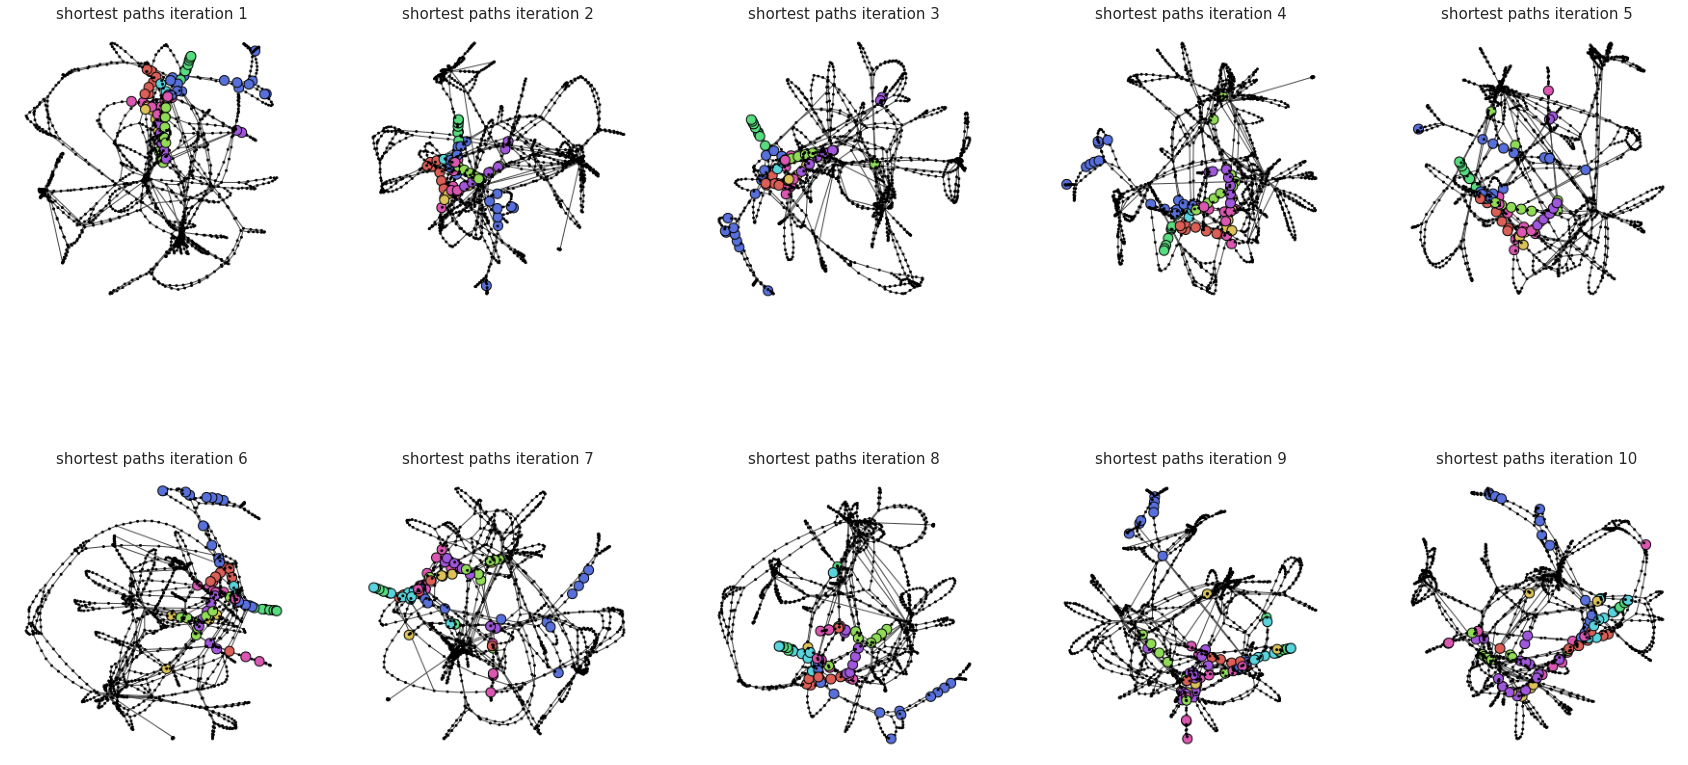

In [200]:
plt.figure(figsize=(30, 15))
plot_shortest_paths()

## Plots

In [208]:
def collect_weights_across_iterations(target_path, metrics):
  # retrieve shortest path weights across the iterations for each monitored pair of nodes
  iteration_weights = []
  for r in metrics.to_dict(orient="records"):
    iteration_weights.append(r['shortest_path_weights'][str(target_path)])
  return iteration_weights

def get_substop_name(target_path, substop_df_path):
  # convert pairs of node ids into the Location names associated with them
  substops = pd.read_excel(substop_df_path)
  start, dest = substops[substops['ID SUBSTOP'] == target_path[0]]['LOCATION'].values[0], substops[substops['ID SUBSTOP'] == target_path[1]]['LOCATION'].values[0]
  return (start, dest)

def plot_results(metrics_df, pairs, substop_path=None, random_ref_nodes=False):
  # random_ref_nodes indicates whether the plots are related to pairs of reference nodes selected at random from the graph or
  # picked from the provided substops
  sns.set_style('dark')
  plt.subplot(131)
  s = sns.lineplot(x='iteration', y='n_clusters', data=metrics)
  s.set_xlabel("Iteration",fontsize=15)
  s.set_ylabel("n_clusters",fontsize=15)
  plt.title(" Number of clusters detected across iterations ", fontsize=20);
  plt.subplot(132)
  s = sns.lineplot(x='iteration', y='n_edges', data=metrics)
  s.set_xlabel("Iteration",fontsize=15)
  s.set_ylabel("n_edges",fontsize=15)
  plt.title(" Number of edges in the graph across iterations ", fontsize=20);
  plt.subplot(133)
  labs = []
  for p in pairs:
    iteration_weights = collect_weights_across_iterations(p, metrics)
    if random_ref_nodes:
      s = sns.lineplot(x='iteration', y=iteration_weights, data=metrics)
    else:
      start, dest = get_substop_name(p, substop_path)
      s = sns.lineplot(x='iteration', y=iteration_weights, data=metrics, label=str((start, dest)))
  plt.legend()
  s.set_xlabel("Iteration",fontsize=15)
  s.set_ylabel("shortest path weight",fontsize=15)
  plt.title(" Change of shortest path total"+"\n"+"weights across iterations ", fontsize=20);

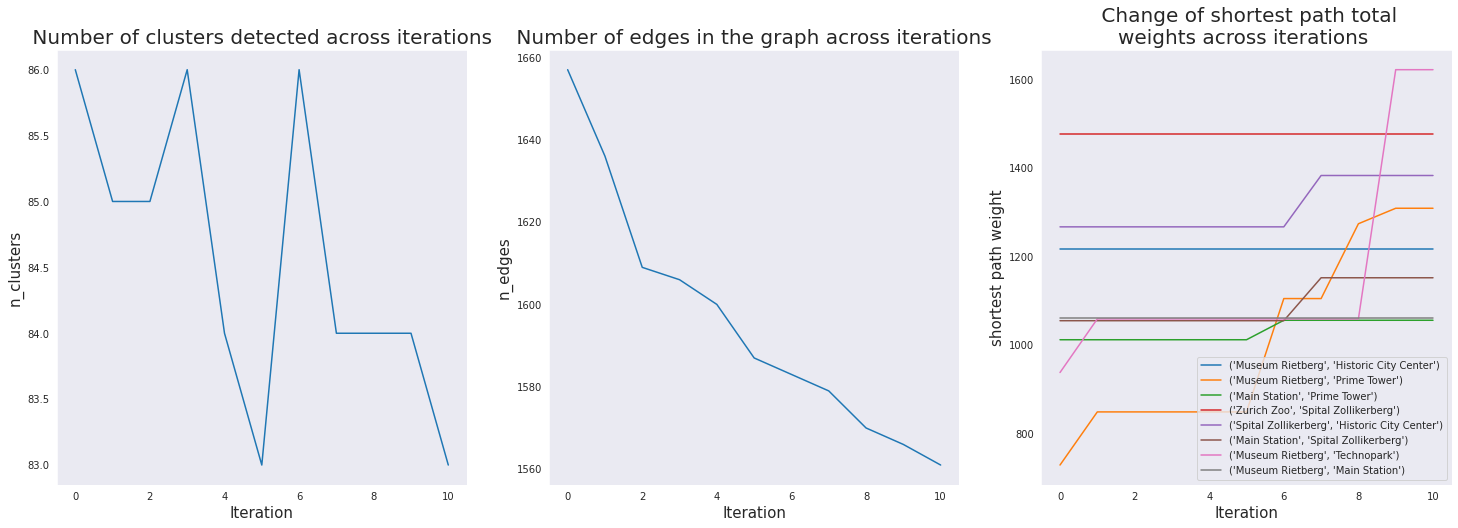

In [209]:
plt.figure(figsize=(25, 8))
plot_results(metrics, pairs, substop_path, random_ref_nodes=False)